---
title: "Análisis exploratorio de datos (EDA)"
subtitle: "Home Credit Default Risk"
author:
  - name: "Gerardo Guerrero"
  - name: "Juan Pablo Cordero"
  - name: "Jerónimo Deli"
  - name: "Romain S"
date: "2025-12-09"
format:
  html:
    theme: default
    toc: false
    code-fold: true
    number-sections: true
execute:
  echo: true
  warning: false
  error: false
jupyter: python3
editor: visual
---

In [ ]:
#| echo: false
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

#display all columns
pd.set_option('display.max_columns', None)

In [125]:
#| echo: false
applications = pd.read_csv('../../data/home-credit-default-risk/application_train.csv')
applications.columns = applications.columns.str.lower()
applications.Name = 'applications'

# Introducción

En este cuaderno, realizaremos un análisis exploratorio de datos (EDA) en el conjunto de datos "Home Credit Default Risk" de [Home Credit Group](https://www.kaggle.com/competitions/home-credit-default-risk/data). El objetivo es comprender mejor las características de los datos previo al desarrollo de modelos predictivos.

![dataset-description](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

In [157]:
display(applications.target.value_counts(normalize=True).to_frame().reset_index(drop=True).T)

,0,1
proportion,0.919271,0.080729


Estamos ante un caso de clasificación binaria, donde el objetivo es predecir si un cliente incumplirá con el pago de un préstamo. La variable objetivo es `TARGET`, que toma el valor 1 si el cliente incumple y 0 en caso contrario.

Esto representa un caso de desbalanceo de clases, ya que la mayoría de los clientes no incumplen con sus pagos. Sin embargo, es crucial identificar a aquellos que sí lo harán para mitigar riesgos financieros. 

En ese sentido, buscaremos obtener un modelo que optimice PR-AUC (Precision-Recall Area Under Curve), ya que nos interesa maximizar el recall minimizando los falsos positivos.

# Applications

Para evitar el data snooping bias, realizamos la división del conjunto de datos en train y test antes de realizar el análisis exploratorio de datos.

Además es importante que esta división se realice de manera estratificada por la variable objetivo, para asegurar que ambas particiones mantengan la misma proporción de clases.

In [165]:
from sklearn.model_selection import train_test_split

X = applications.drop(columns=['target'])  # Variables predictoras
y = applications['target']                 # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

app = pd.concat([X_train, y_train], axis=1)
app.Name = 'applications_train'

In [189]:
def calculate_correlation_between_features(df, features, top_k=20):
    corr_matrix = df[features].corr().abs()
    
    # Máscara para quedarte solo con la mitad superior
    mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=0)
    corr_tri = corr_matrix.mask(mask)

    plt.figure(figsize=(10, 8))
    im = plt.imshow(corr_tri, cmap='coolwarm', vmin=0, vmax=1)
    plt.colorbar(im, label='Correlación absoluta')

    plt.xticks(ticks=np.arange(len(features)), labels=features, rotation=90)
    plt.yticks(ticks=np.arange(len(features)), labels=features)

    plt.title('Matriz de correlación')
    plt.tight_layout()
    plt.show()

    # Obtener solo la mitad superior para evitar duplicados y diagonal
    pairs = []
    n = len(features)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((
                features[i],
                features[j],
                corr_matrix.iloc[i, j]
            ))

    # Ordenar por correlación de mayor a menor
    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:top_k]

    # Preparar datos para graficar
    pair_labels = [f"{a} – {b}" for a, b, _ in pairs_sorted]
    corr_values = [c for _, _, c in pairs_sorted]

    fig, ax = plt.subplots(figsize=(8, 0.4 * top_k + 1))

    # “Heatmap” vertical de una sola columna
    im = ax.imshow(
        np.array(corr_values)[..., None],  # shape (top_k, 1)
        cmap='coolwarm',
        vmin=0,
        vmax=1,
        aspect='auto'
    )

    # Etiquetas en el eje y: los pares
    ax.set_yticks(np.arange(top_k))
    ax.set_yticklabels(pair_labels)
    ax.set_xticks([0])
    ax.set_xticklabels(["Correlación"])

    # Poner el valor de corr y el nombre del par dentro de la celda (si quieres solo el valor, quita el label)
    for i, (label, val) in enumerate(zip(pair_labels, corr_values)):
        ax.text(
            0, i,
            f"{val:.2f}",
            ha='center', va='center',
            fontsize=8
        )

    plt.colorbar(im, label='Correlación absoluta')
    plt.title(f'Top {top_k} pares de variables más correlacionados')
    plt.tight_layout()
    plt.show()

    

def calculate_correlation_with_target(df):
    num_cols = df.select_dtypes(include=['float64','int64']).columns
    num_cols = num_cols.drop('target')   # exclude target

    # Serie con correlación de cada numérica contra target
    corr_with_target = df[num_cols].corrwith(df['target']).dropna()

    # Ordenar por valor absoluto (mayor importancia primero)
    order = corr_with_target.abs().sort_values(ascending=False).index
    corr_sorted = corr_with_target.loc[order]

    # Plot horizontal (mayores correlaciones arriba), coloreando por signo
    plt.figure(figsize=(6, max(6, len(corr_sorted) * 0.12)))
    colors = ['tab:red' if v > 0 else 'tab:blue' for v in corr_sorted.values]
    y = np.arange(len(corr_sorted))

    plt.barh(y, corr_sorted.values, color=colors)
    plt.yticks(y, corr_sorted.index, fontsize=8)
    plt.gca().invert_yaxis()  # poner la mayor correlación arriba
    plt.xlabel('Correlación con target')
    plt.title("Correlación de 'target' con variables numéricas (ordenado por |corr|)")
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    strong_corr = corr_sorted.head(20)

    return strong_corr


def calculate_lift(df):
    num_cols = df.select_dtypes(include=['float64','int64']).columns
    num_cols = num_cols.drop('target')   # exclude target

    aux = df[num_cols].groupby(df.target).mean().T
    aux['lift'] = aux[1] / aux[0]
    aux = aux.sort_values(by='lift', ascending=False)
    display(aux.head(20))
    display(aux.tail(20))

    top_lift = aux.head(20)['lift']
    bottom_lift = aux.tail(20)['lift']

    strong_lifts = pd.concat([top_lift, bottom_lift])

    return strong_lifts

def display_nan_percentage(df):
    nan_percentage = df.isna().mean() * 100
    nan_percentage = nan_percentage[nan_percentage > 0].sort_values(ascending=False).head(20)

    display(nan_percentage.head(10).to_frame(name='Top 10 % of NaN values'))
    display(nan_percentage.tail(10).to_frame(name='Bottom 10 % of NaN values'))

def plot_distributions(df, dtype):

    columns = df.select_dtypes(include=dtype).columns

    n = len(columns)
    ncols = 3
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3))
    axes = axes.flatten()

    if (isinstance(dtype, str) and dtype == 'object') or (isinstance(dtype, (list, tuple)) and 'object' in dtype):
        # categorical variables
        if len(columns) == 0:
            plt.close()
            return
        for i, col in enumerate(columns):
            counts = df[col].value_counts().sort_values(ascending=True).head(20)

            axes[i].barh(counts.index.astype(str), counts.values)
            axes[i].set_title(col)
            axes[i].tick_params(axis='x', rotation=45, pad=3)

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
    else:
        for i, col in enumerate(columns):
            axes[i].hist(df[col].dropna(), bins=20)
            axes[i].axvline(df[col].mean(), color='red', linestyle='--')
            axes[i].set_title(col)

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def data_snooping(df):
    display(Markdown(f"The dataset {df.Name} contains {df.shape[0]} observations and {df.shape[1]} columns. \n"))

    display(Markdown("## Number of rows by target class:"))
    display(df.target.value_counts().to_frame())
    print()

    display(Markdown("## Number of columns by data type:"))
    display(df.dtypes.value_counts().to_frame())
    print()

    display(Markdown("## Percentage of NaN values per column:"))
    display_nan_percentage(df)
    print()

    display(Markdown("## Distribution of categorical variables:"))
    plot_distributions(df, dtype='object')
    print()

    display(Markdown("## Distribution of numerical variables:"))
    plot_distributions(df, dtype=['float64','int64'])
    print()

    display(Markdown("## Lift analysis of numerical variables:"))
    strong_lifts = calculate_lift(df)
    print()

    display(Markdown("## Correlation of numerical variables with target:"))
    print()
    strong_corr = calculate_correlation_with_target(df)
    candidate_features_df = pd.concat([strong_corr.to_frame(name='correlation'), strong_lifts.to_frame(name='lift')], axis=1).sort_values(by='correlation',key=abs, ascending=False)
    candidate_features = list(candidate_features_df.index)

    display(Markdown("## Correlation between candidate features:"))
    calculate_correlation_between_features(df, candidate_features, top_k=30)



The dataset applications_train contains 246008 observations and 122 columns. 


## Number of rows by target class:

,count
target,
0,226148
1,19860


## Number of columns by data type:

,count
float64,65
int64,41
object,16


## Percentage of NaN values per column:

,Top 10 % of NaN values
commonarea_medi,69.839599
commonarea_avg,69.839599
commonarea_mode,69.839599
nonlivingapartments_medi,69.399776
nonlivingapartments_mode,69.399776
nonlivingapartments_avg,69.399776
fondkapremont_mode,68.377858
livingapartments_mode,68.338835
livingapartments_medi,68.338835
livingapartments_avg,68.338835


,Bottom 10 % of NaN values
floorsmin_mode,67.851858
floorsmin_medi,67.851858
floorsmin_avg,67.851858
years_build_mode,66.478732
years_build_medi,66.478732
years_build_avg,66.478732
own_car_age,66.021430
landarea_avg,59.341566
landarea_medi,59.341566
landarea_mode,59.341566


## Distribution of categorical variables:

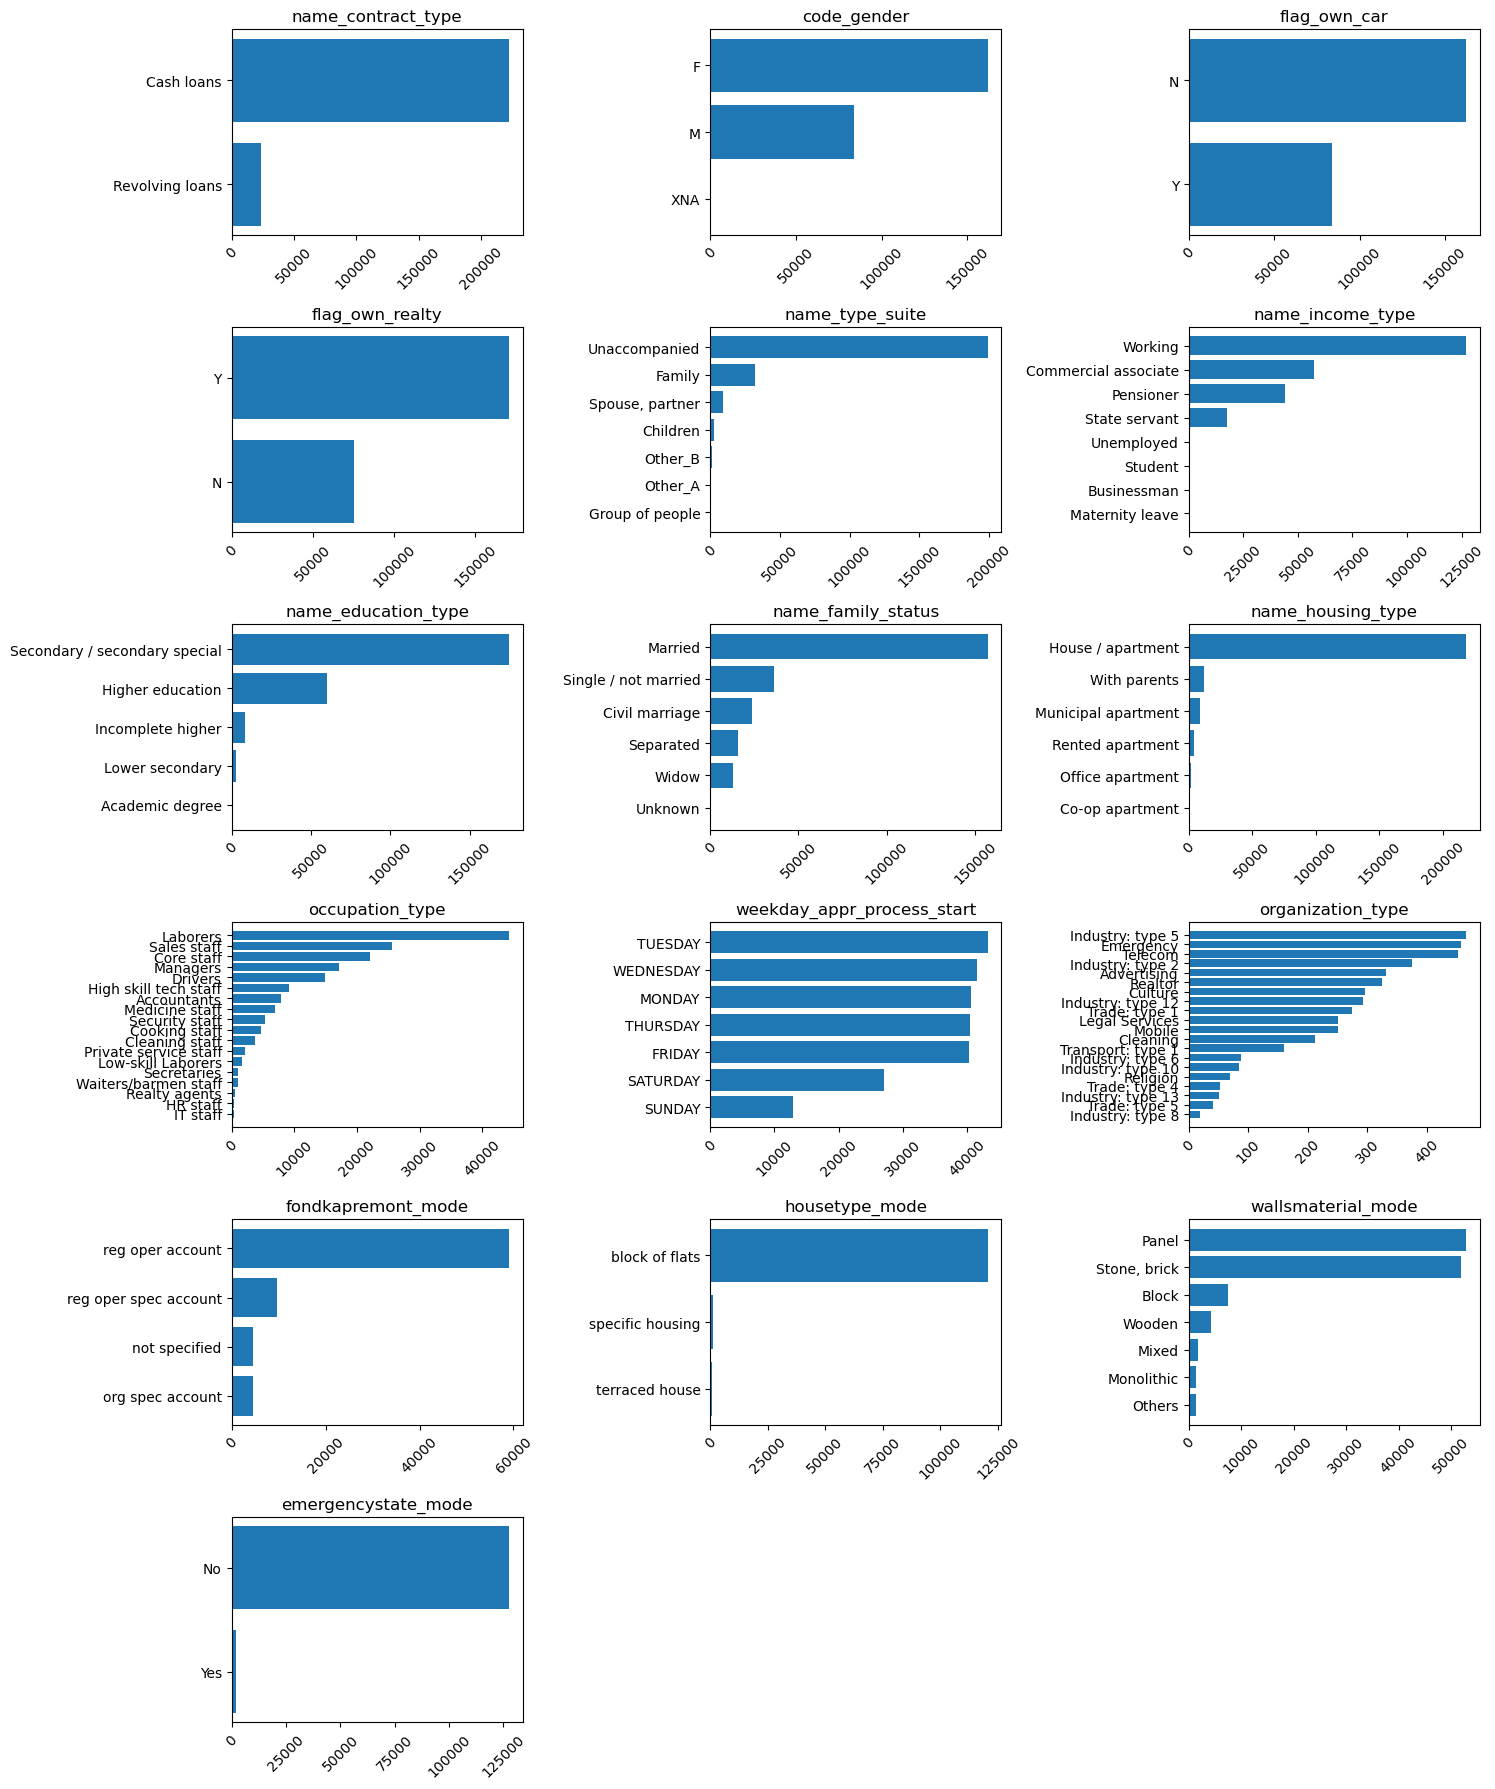

## Distribution of numerical variables:

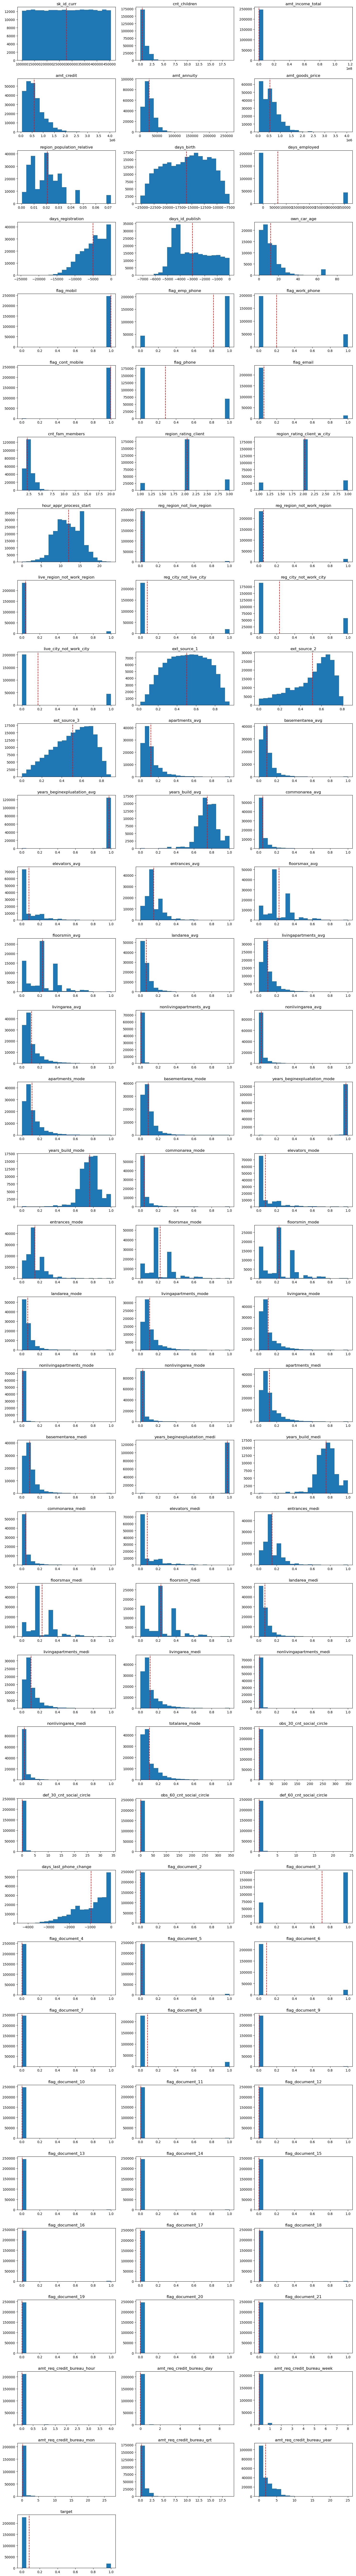

## Lift analysis of numerical variables:

target,0,1,lift
flag_document_2,0.000035,0.000151,4.270166
flag_document_21,0.000296,0.000604,2.039482
reg_city_not_live_city,0.074270,0.119184,1.604745
def_60_cnt_social_circle,0.096136,0.138693,1.442677
def_30_cnt_social_circle,0.139221,0.191900,1.378391
reg_city_not_work_city,0.224592,0.304532,1.355934
live_city_not_work_city,0.176561,0.223615,1.266502
flag_document_20,0.000495,0.000604,1.220047
flag_work_phone,0.196327,0.237865,1.211575
amt_req_credit_bureau_day,0.006789,0.008159,1.201803


target,0,1,lift
flag_document_7,0.000190,0.000151,0.794450
ext_source_2,0.523343,0.411379,0.786061
elevators_mode,0.075651,0.058842,0.777811
elevators_medi,0.079353,0.061334,0.772924
elevators_avg,0.080206,0.061963,0.772542
flag_document_11,0.003940,0.003021,0.766809
ext_source_1,0.510996,0.386216,0.755811
ext_source_3,0.520985,0.390899,0.750307
flag_document_9,0.003935,0.002870,0.729287
flag_document_18,0.008331,0.005942,0.713205


## Correlation of numerical variables with target:

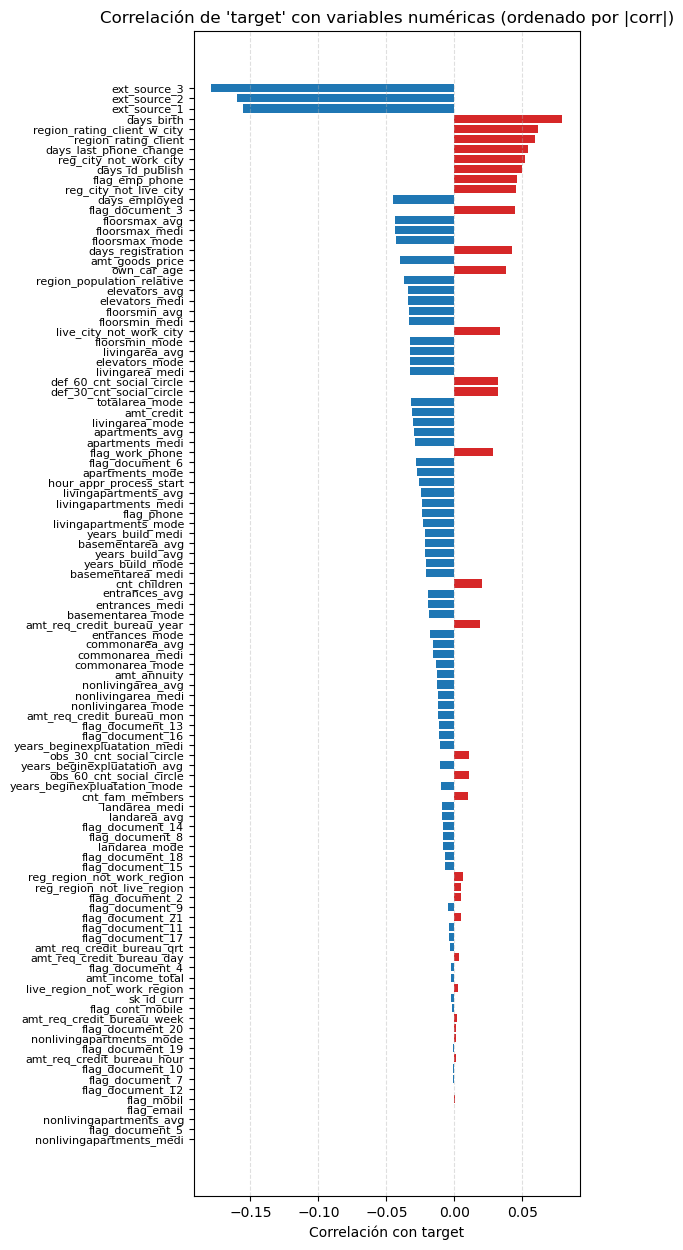

## Correlation between candidate features:

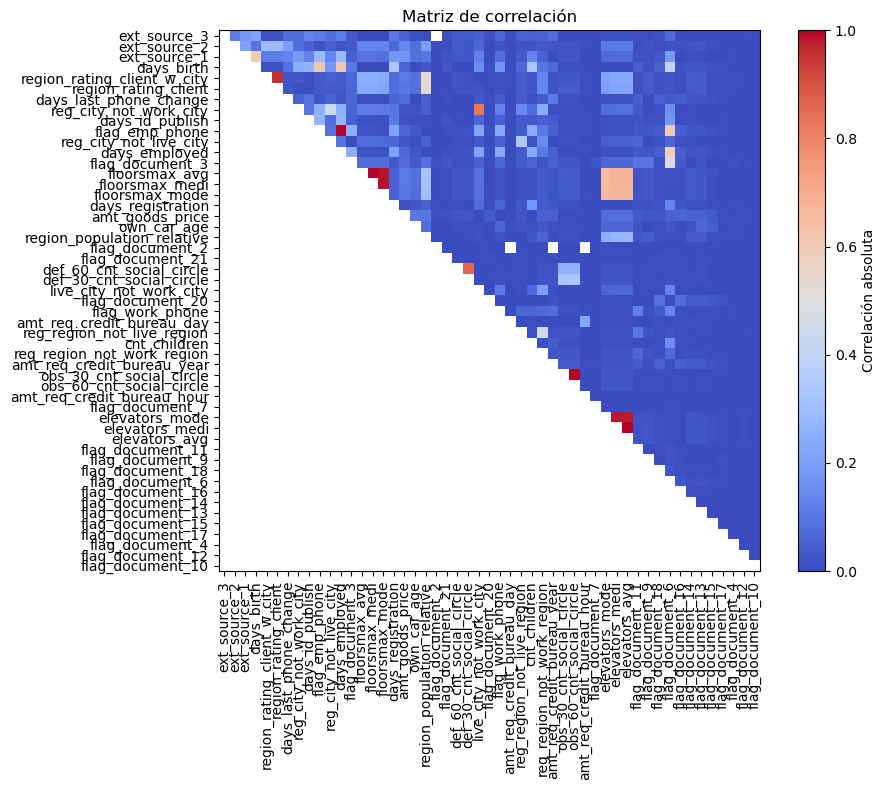

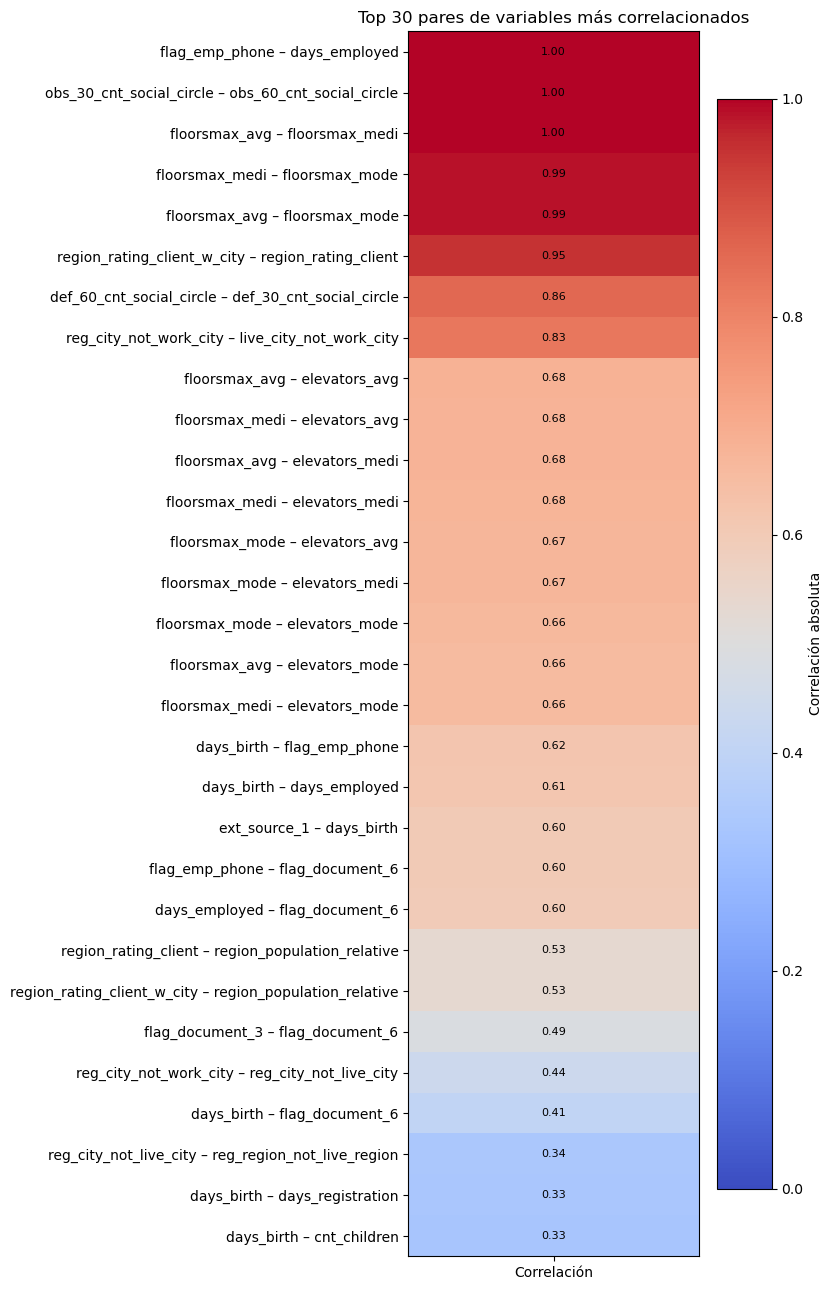

In [190]:
data_snooping(app)